# Generating Mock Data for Spatial Data Science

*Mock data is useful to design new experiments, test new analytical techniques, evaluating the performance of data systems, and to generally get a handle on a new analytical problem, among other things. In some instances, mock data is the goal - think video games or other virtual worlds that need to have endless horizons. In other cases, mock data is to help us think through a problem or test a system. This later case is our primary use in spatial data science, where mock data helps us think through the data modeling challenge. Specifically, it helps us think about the pros and cons of different approaches to problem formulation, abstraction, and representation of the spatial entities and their attributes.*

Last updated: Nov 16, 2023

In [1]:
# Imports
import os
from datetime import datetime, timedelta

os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

# Time Series Data

Spatiotemporal data is a huge topic in spatial data science, and dealing with dates and times can be tricky sometimes. With Pandas and NumPy we can generate synthetic time series quite easily and combine them with spatial data to create robust mock spatiotemporal data. We can even use different methods to make the time series a little more believable than simply randomly generating values with no regard for temporal autocorrelation.

In this notebook, we will expand upon the ideas of multivariate distributions to simply capture another dimension of the mock data, the temporal dimension.

### Simple Time Series

To create a simple, random time series (with no spatial data), Pandas allows us to easily create a range of dates and store them in a DataFrame. This makes it easy then to use a probability distribution to randomly generate values and assign those values to the timesteps of the DataFrame.

In [2]:
# Generate time series
start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2023-12-31")
num_days = (end_date - start_date).days + 1

dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [3]:
# Generate observations for time series
observations = np.random.uniform(0, 30, num_days)

In [4]:
# Create DataFrame
time_series_df = pd.DataFrame({'Date': dates, 'Observation': observations})

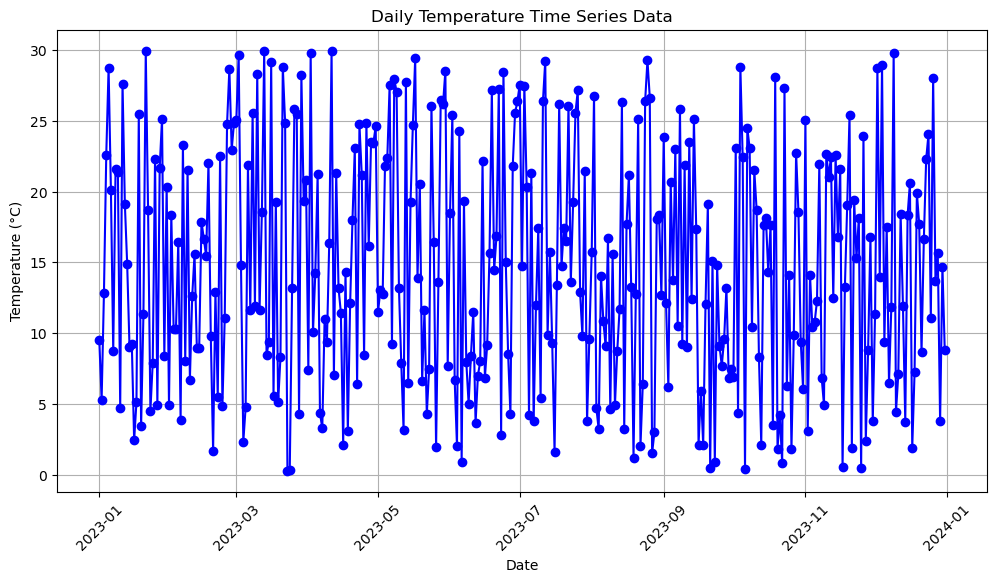

In [5]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_series_df['Date'], time_series_df['Observation'], color='b', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature Time Series Data')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Sine Wave with Noise

This provides a good starting point, but intuitively, it doesn't seem very believable to have completely random values across the span of a year, especially for something like temperature which has strong ties to the different seasons. To account for this, we can use a sine wave (think back to high school trigonometry) and then randomly add noise to the signal, to create a more realistic looking time series.

In [6]:
# Create time series
time = pd.date_range(start="2023-01-01", periods=365, freq="D")

In [7]:
# Settings for simulated time series
mean_temperature = 50
amplitude = 50
frequency = 2 * np.pi / 365
phase = -np.pi / 2

time_range = np.arange(365)
noise = np.random.normal(0, 5, 365)

# Creating Signal
temperature = mean_temperature + amplitude * np.sin(frequency * time_range + phase) + noise

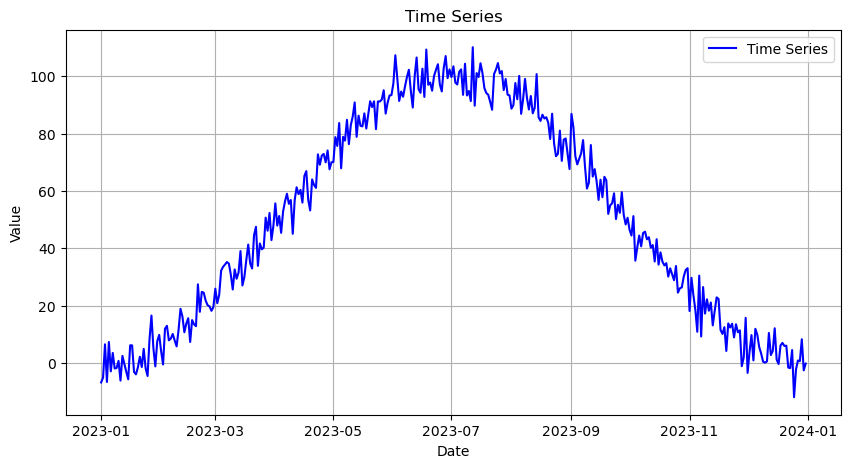

In [8]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, temperature, label="Time Series", color='blue')
plt.title("Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

### Time Series with Point Data

Now that we know a couple different ways to create time series, it's just a matter of combining the time series with spatial data.

Points can be randomly generated just as they have been done in other notebooks, and then for each point, a time series can be created and we will end up with many points at the same location, each representing a different value of the time series. This is what sensor data looks like!

In the end, we will create a total number of observations equal to the number of points/sensors/locations times the length of the time series. In the demo below, this means that with 25 points and a year's worth of daily observations (365 observations for each point), the total number of rows in the output GeoDataFrame will be `25 * 365`, or `9125`.

In [9]:
# Define the bounding box (extent)
xmin, ymin, xmax, ymax = (0, 0, 10, 10)

# Generate random point coordinates
num_points = 25

x = np.random.uniform(xmin, xmax, num_points)
y = np.random.uniform(ymin, ymax, num_points)

In [10]:
# Create a GeoDataFrame from the random points
point_geometry = [Point(x[i], y[i]) for i in range(num_points)]

point_gdf = gpd.GeoDataFrame(geometry=point_geometry)

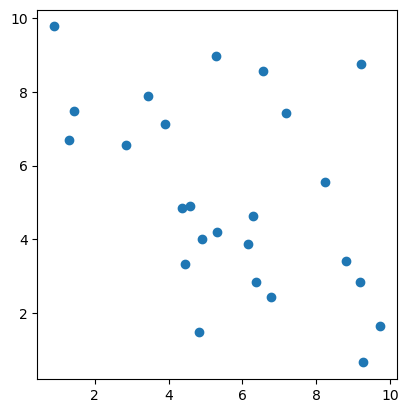

In [11]:
# Plot
point_gdf.plot();

In [12]:
# Loop through Points and extract geoms
points = []

for value in point_gdf["geometry"]:
    points.append(value)

In [13]:
# Create Time Series Data for Points
ts_data = []

for p in points:
    # Create time series
    time = pd.date_range(start="2023-01-01", periods=365, freq="D")
    
    # Settings for simulated time series
    mean_temperature = 50
    amplitude = 50
    frequency = 2 * np.pi / 365
    phase = -np.pi / 2

    time_range = np.arange(365)
    noise = np.random.normal(0, 5, 365)

    # Creating Signal
    temperature = mean_temperature + amplitude * np.sin(frequency * time_range + phase) + noise
    
    # Add tuple of point, date, and observation to list
    for i in range(len(temperature)):
        ts_data.append((temperature[i], time[i], p))


In [14]:
# Convert to GDF
ts_df = pd.DataFrame(ts_data, columns=["observation", "date", "geometry"])

ts_gdf = gpd.GeoDataFrame(ts_df, geometry="geometry")

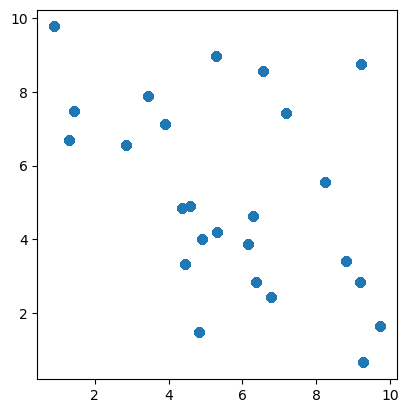

In [15]:
# Plot
ts_gdf.plot();

In [16]:
ts_gdf

,observation,date,geometry
0,7.017576,2023-01-01,POINT (4.59323 4.90795)
1,-0.614930,2023-01-02,POINT (4.59323 4.90795)
2,-4.095873,2023-01-03,POINT (4.59323 4.90795)
3,-0.316644,2023-01-04,POINT (4.59323 4.90795)
4,-5.486348,2023-01-05,POINT (4.59323 4.90795)
...,...,...,...
9120,1.072966,2023-12-27,POINT (9.19843 2.83940)
9121,-0.331013,2023-12-28,POINT (9.19843 2.83940)
9122,2.561735,2023-12-29,POINT (9.19843 2.83940)
9123,4.432708,2023-12-30,POINT (9.19843 2.83940)


### Brownian Motion & Random Walks

Another key form of spatiotemporal data is trajectory data. We can use trajectories to show movement of agents or features across space. Here, we will model movement using an agent that makes use of the ideas of Brownian Motion and Random Walks. At each step (new location), we can then assign a temporal component, and could even add some sort of attribute data too.

For more detailed information and examples, see this [repo](https://github.com/runck014/geometric-brownian-motion), which goes into these ideas more thoroughly.

The code used below is heavily inspired (mostly copied) from the repo linked above.

In [17]:
class Agent:
    def __init__(self, x_start, y_start, simulation_duration=1440, start_date=datetime(2023, 10, 10, 0, 0, 0), time_increment=timedelta(minutes=1)):
        # Setting parameters
        self.simulation_duration = simulation_duration
        self.time_steps_remaining = simulation_duration
        self.current_x = x_start
        self.current_y = y_start
        self.memory_x = []
        self.memory_y = []
        self.current_time = start_date
        self.time_increment = time_increment
        
        
    def step(self):
        # Save current location to memory
        self.save_location()
        
        # Randomly move to a new location
        self.move()
        
        # Update time
        self.current_time += self.time_increment
        
        # Change time remaining to t-1
        self.time_steps_remaining -= 1

    
    def move(self):
        # Change location to somewhere within +/- 1 unit of distance
        self.current_x = self.current_x + np.random.uniform(-1, 1)
        self.current_y = self.current_y + np.random.uniform(-1, 1)
        
    
    def save_location(self):
        # Save location to memory
        self.memory_x.append(self.current_x)
        self.memory_y.append(self.current_y)
        
        
    def run(self):
        # Continue simulating throughout duration of simulation
        while self.time_steps_remaining > 0:
            self.step()

    def get_time_series(self):
        # Only allow after running simulation
        if self.time_steps_remaining != 0:
            raise Exception("Simulation not complete! Run simulation first.")
        
        # Create a time series using Pandas
        time_series_data = {
            'Time': [self.current_time - i * self.time_increment for i in range(len(self.memory_x))],
            'X': self.memory_x,
            'Y': self.memory_y
        }
        time_series_df = pd.DataFrame(time_series_data)
        return time_series_df

In [18]:
# Create agent and run simulation
agent = Agent(0, 0)

agent.run()

In [19]:
# Create time series DF
agent.get_time_series()

,Time,X,Y
0,2023-10-11 00:00:00,0.000000,0.000000
1,2023-10-10 23:59:00,-0.821251,0.929088
2,2023-10-10 23:58:00,-0.688520,-0.013688
3,2023-10-10 23:57:00,-1.100563,-0.366592
4,2023-10-10 23:56:00,-0.690161,-1.103645
...,...,...,...
1435,2023-10-10 00:05:00,-11.589521,-26.898375
1436,2023-10-10 00:04:00,-11.879213,-26.710164
1437,2023-10-10 00:03:00,-11.492057,-26.094257
1438,2023-10-10 00:02:00,-12.391462,-26.600792


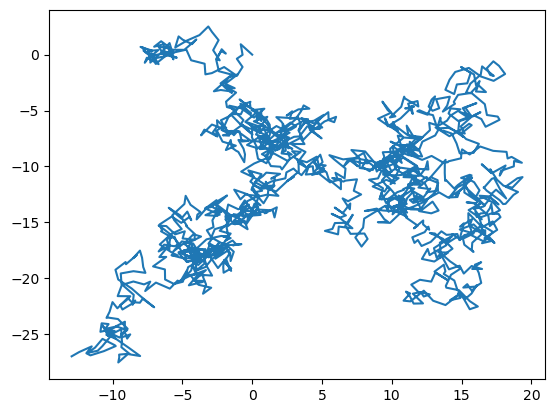

In [20]:
# Plotting movement
plt.plot(agent.memory_x, agent.memory_y)
plt.show()